# **Download dataset from Kaggle**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"immanuelmayerd","key":"c0af11c2081e01520dcaa4c65a5076b8"}'}

Run this cell to install kaggle dependency, copy the file into ~/.kaggle/kaggle.json, and change file permissions to 600.

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download all the dataset using this command below.

In [3]:
!kaggle datasets download -d immanuelmayerd/14-indonesian-wayang-types

 33% 9.00M/27.3M [00:01<00:03, 5.28MB/s]
100% 27.3M/27.3M [00:01<00:00, 16.8MB/s]


Unzip the .zip file so we can see the DATASET folders. There are few version of the dataset since we experiment with different amount of Batik motives.

In [4]:
!unzip -qq /content/14-indonesian-wayang-types

# **Import All Dependencies**

In [5]:
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np
import os

In [72]:
cwd = os.getcwd()
IMAGE_SHAPE = (160, 160)
TRAINING_DATA_DIR = os.path.join(cwd,"DATASET","TRAIN")
VALID_DATA_DIR = os.path.join(cwd,"DATASET","TEST")

In [73]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    TRAINING_DATA_DIR,
    shuffle=True,
    target_size=IMAGE_SHAPE,
)
valid_generator = datagen.flow_from_directory(
    VALID_DATA_DIR,
    shuffle=False,
    target_size=IMAGE_SHAPE,
)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.


In [74]:
train_path = '/content/DATASET/TRAIN'
test_path = '/content/DATASET/TEST'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=45,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

types_dict = train_generator.class_indices
print(types_dict)

Found 1120 images belonging to 14 classes.
Found 280 images belonging to 14 classes.
{'Abimanyu': 0, 'Antasena': 1, 'Arjuna': 2, 'Bagong': 3, 'Bima': 4, 'Cepot': 5, 'Gareng': 6, 'Gatot Kaca': 7, 'Hanoman': 8, 'Kresna': 9, 'Nakula': 10, 'Petruk': 11, 'Semar': 12, 'Yudhistira': 13}


In [75]:
#base model MobileNetV2
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3),
    pooling='max'
)

base_model.trainable = True

9420800/9406464 [==============================] - 0s 0us/step


In [76]:
#base model VGG16 (untuk saat ini jelek)

#from tensorflow.keras.applications.vgg16 import VGG16

#base_model = VGG16(
#    include_top=False,
#    weights='imagenet',
#    input_shape=(224, 224, 3),
#    pooling='avg'
#)

In [77]:
def scheduler(epoch, lr):
  if epoch <= 50:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [78]:
EPOCHS = 100
LEARNING_RATE = 1e-4
TRAIN_STEP = 700//20
VAL_STEP = 200//20

Loop Starts here :

In [100]:
clear_session()

model = Sequential([
    base_model,
    Dense(512, activation='relu',
          kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
    ),
    Dropout(0.3),
    Dense(14, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [101]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                7182      
                                                                 
Total params: 2,921,038
Trainable params: 2,886,926
Non-trainable params: 34,112
_________________________________________________________________


In [102]:
chckp = tf.keras.callbacks.ModelCheckpoint("./model_best.h5", monitor='val_accuracy', mode='max', save_best_only=True )

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
    callbacks=[lr_callback, chckp]
)

Epoch 1/100
35/35 [==============================] - 14s 230ms/step - loss: 2.5157 - accuracy: 0.4614 - val_loss: 1.1277 - val_accuracy: 0.7550 - lr: 1.0000e-04
Epoch 2/100
35/35 [==============================] - 7s 203ms/step - loss: 0.8103 - accuracy: 0.8171 - val_loss: 1.0273 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 3/100
35/35 [==============================] - 7s 188ms/step - loss: 0.6119 - accuracy: 0.8914 - val_loss: 1.1074 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 4/100
35/35 [==============================] - 7s 188ms/step - loss: 0.5900 - accuracy: 0.8829 - val_loss: 1.0882 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 5/100
35/35 [==============================] - 7s 202ms/step - loss: 0.5541 - accuracy: 0.9143 - val_loss: 0.9379 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 6/100
35/35 [==============================] - 7s 188ms/step - loss: 0.4859 - accuracy: 0.9300 - val_loss: 1.1991 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 7/100
35/35 [====================

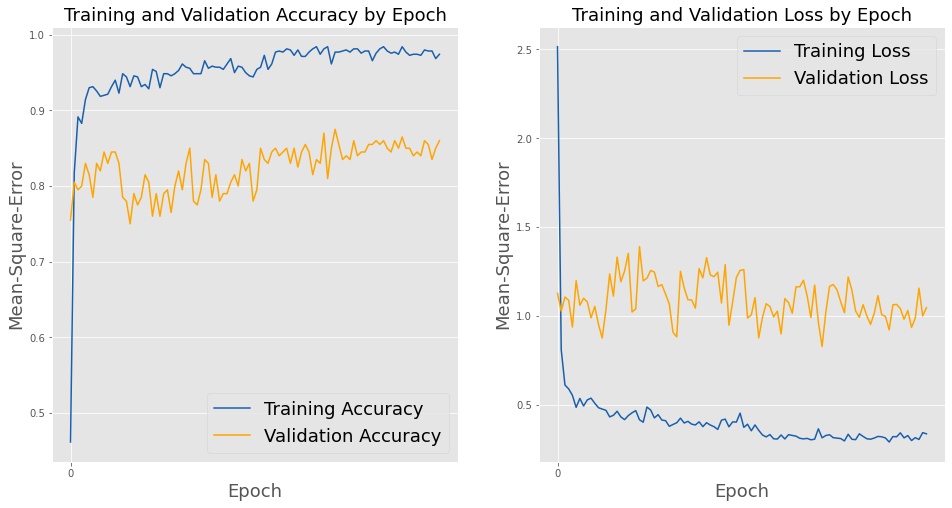

In [103]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss= history.history['val_loss']

plt.figure(figsize=(16, 8))

# Cek hasil akurasi
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

plt.title('Training and Validation Accuracy by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))

plt.legend(fontsize = 18);

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(val_loss, label='Validation Loss', color='orange')

plt.title('Training and Validation Loss by Epoch', fontsize = 18)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Mean-Square-Error', fontsize = 18)
plt.xticks(range(0,16,20), range(0,16,20))


plt.legend(fontsize = 18)

In [104]:
model.load_weights("./model_best.h5")

In [105]:
validation_generator_2 = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE,
    class_mode='categorical',
    batch_size = 256,
    color_mode='rgb'
)

avg_loss = 0
avg_accc = 0

for x_test, y_test in validation_generator_2:
  eval_result = model.evaluate(x_test,y_test)

  if avg_loss == 0:
    avg_loss = eval_result[0]
  else:
    avg_loss = (eval_result[0] + avg_loss) / 2

  if avg_accc == 0:
    avg_accc = eval_result[1]
  else:
    avg_accc = (eval_result[1] + avg_loss) / 2

  if 1 >= len(x_test) / 256:
    break

print("Loss of the model is     -" , avg_loss)
print("Accuracy of the model is -" , avg_accc*100 , "%")

Found 280 images belonging to 14 classes.
8/8 [==============================] - 1s 33ms/step - loss: 0.9214 - accuracy: 0.8594
Loss of the model is     - 0.9213908314704895
Accuracy of the model is - 85.9375 %


# **Save The Model and Convert to .tflite**

In [106]:
model_save_path = "saved_model/15_motives"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models', exist_ok=True)
with open('tflite_models/wayang_types.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: saved_model/15_motives/assets


INFO:tensorflow:Assets written to: saved_model/15_motives/assets
